In [111]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.colors
import statsmodels.formula.api as smf
import seaborn as sns
from cem.match import match
from cem.coarsen import coarsen
from cem.imbalance import L1
import statsmodels.api as sm


In [112]:
matplotlib.rc('font', family='Arial') 

In [113]:

pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df=pop_df[['Country Code','2019']].dropna()
pop_df['2019']=pop_df['2019'].astype(int)
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values
possible_countries=[x.lower() for x in possible_countries]

In [114]:

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ'
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]

In [115]:

possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))

In [145]:
df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df=df[df['country'].isin(possible_iso)]
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df = df[df['year'].isin(range(2008, 2014))]
#df=df[df['Aff_country']!=df['Mention_country']]

Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df=df[~df['subjarea'].isin(physical_sciences)]
df['post']=df['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )


In [129]:
    country_colors_manual = {
        'EGY': 'C0',  # Egypt
        'TUN': 'C1',  # Tunisia
        'LBY': 'C2',  # Libya 
        'SYR': 'C3',  # Syria
        'YEM': 'C4',  # Yemen
        'BHR': 'C5',  # Bahrain
        
        'JOR': 'C6',  # Jordan
        'KWT': 'C7',  # Kuwait
        'MAR': 'C8', 
          # Morocco
        'OMN': 'C9',  # Oman
    }

Text(0.5, 0, 'Average Foreign Attention')

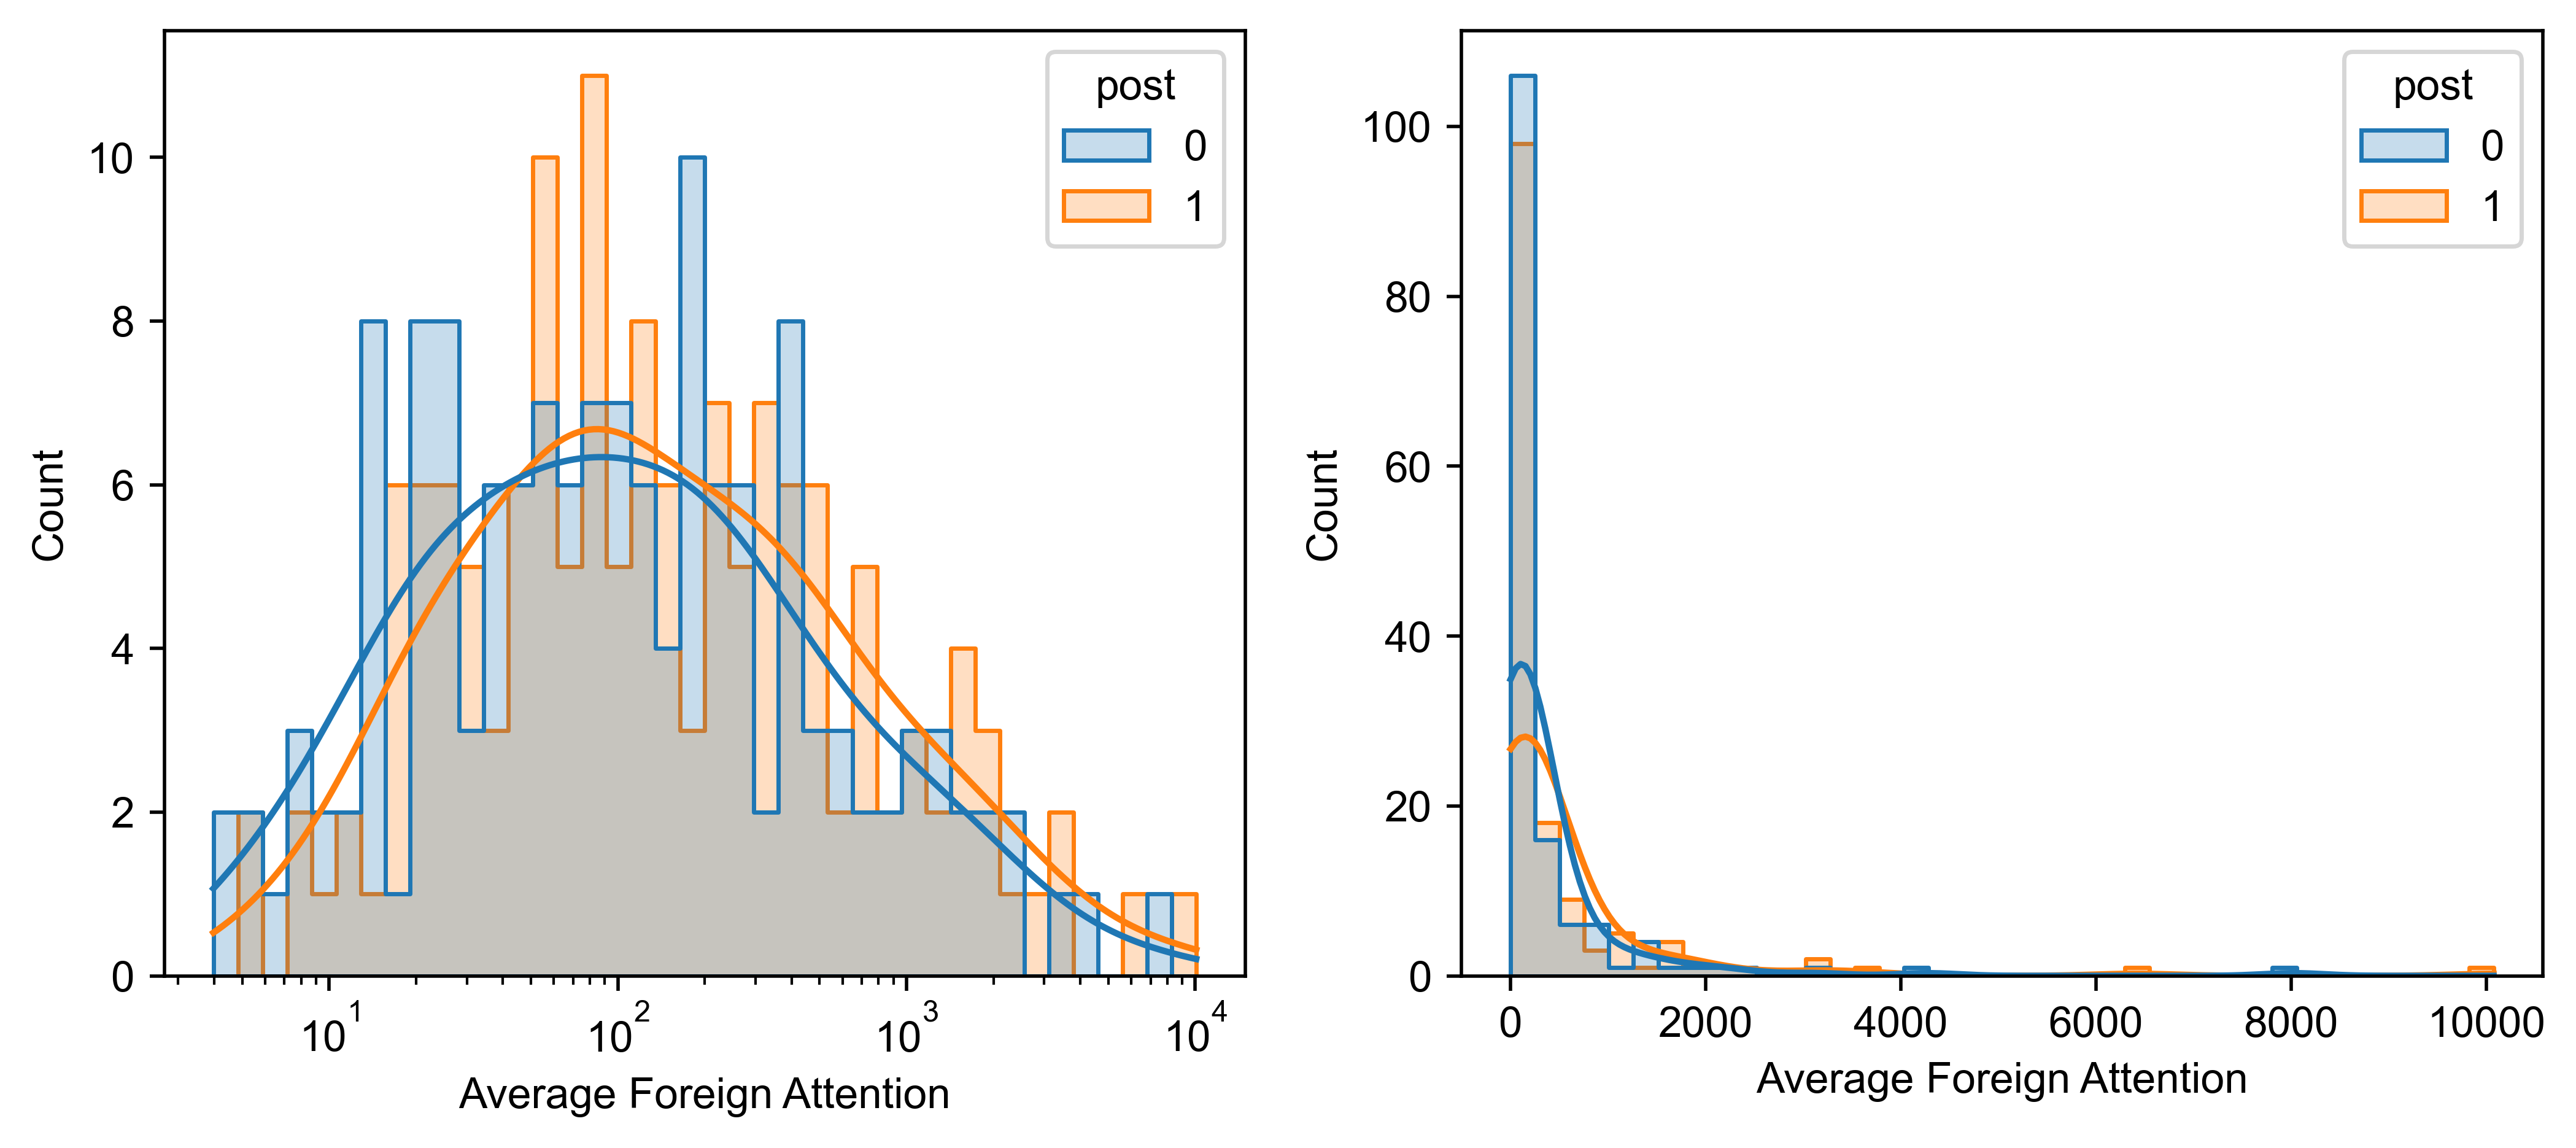

In [146]:
pff_df=df.groupby(['Mention_country', 'post'])['count'].sum().reset_index()
pff_df['count']/=9
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=500)
sns.histplot(pff_df, x='count', hue='post', log_scale=(True, False), bins=40, kde=True, element='step', ax=ax[0])
sns.histplot(pff_df, x='count', hue='post', bins=40, kde=True, element='step', ax=ax[1])
ax[0].set_xlabel('Average Foreign Attention')
ax[1].set_xlabel('Average Foreign Attention')

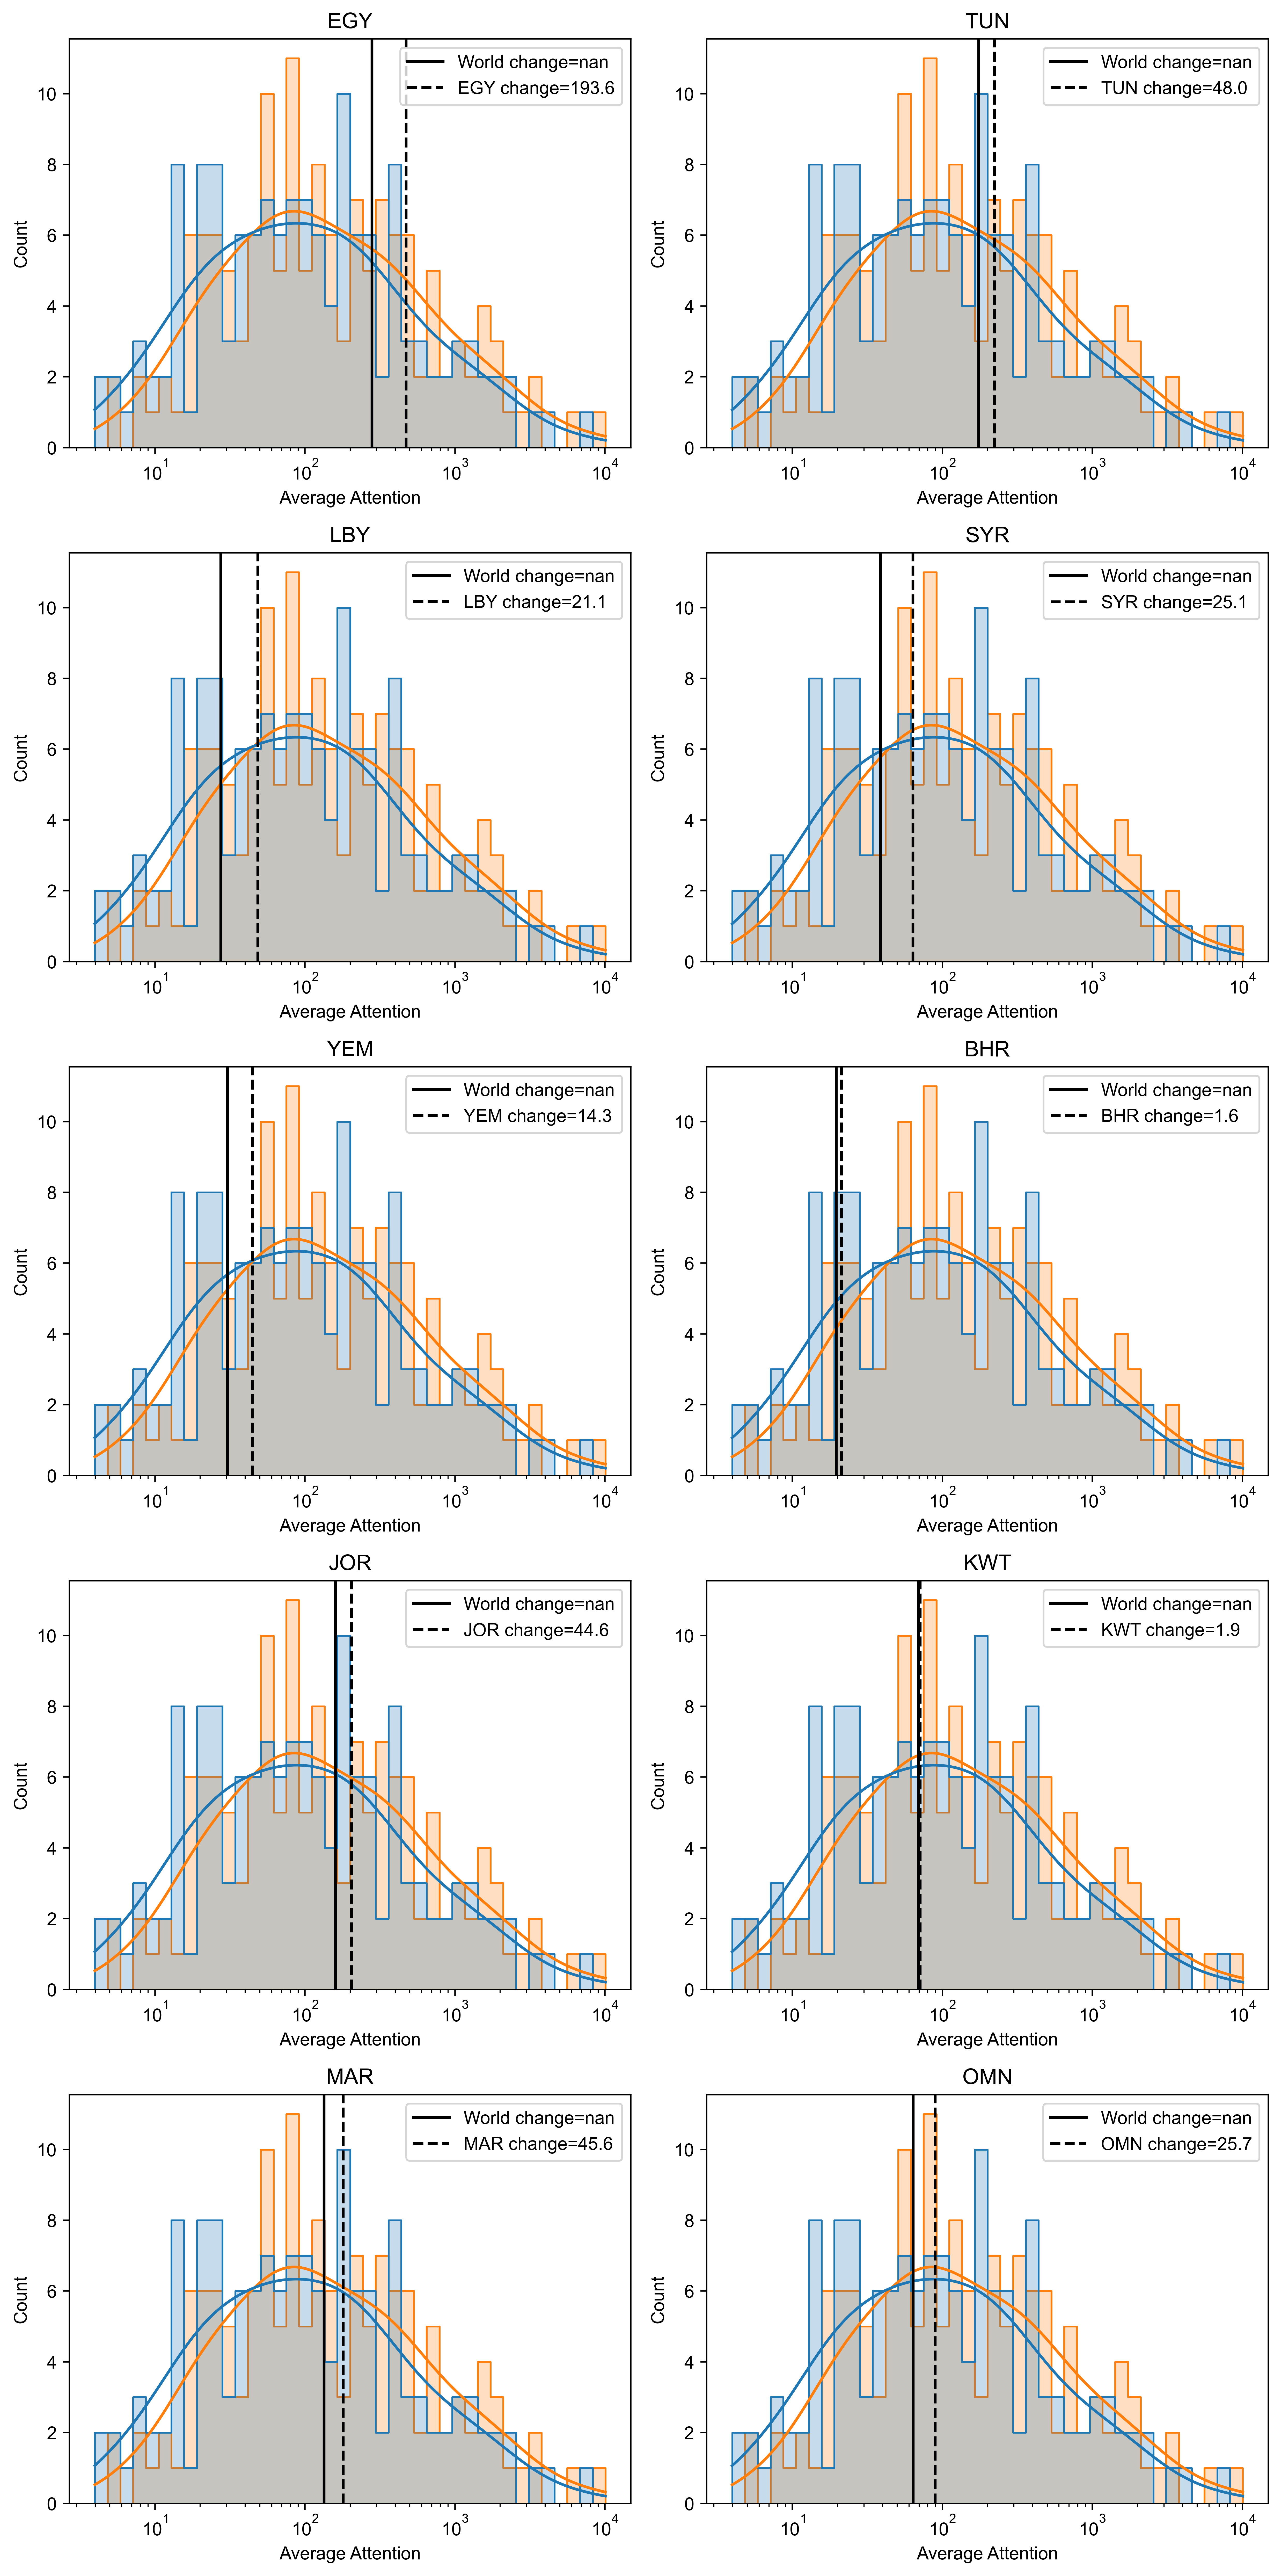

In [147]:
pff_df=df.groupby(['Mention_country', 'post'])['count'].sum().reset_index()
pff_df['count']/=9

df_sample=df.groupby(['Mention_country','post'])['count'].sum().reset_index()
df_sample['count']/=9
df_sample['log_count']=np.log10(df_sample['count'])

fig, ax=plt.subplots(nrows=5, ncols=2, figsize=(10, 20), dpi=500)
ax=ax.flat
for i, c in enumerate(abbr):
    sns.histplot(pff_df, x='count', hue='post', log_scale=(True, False), bins=40, kde=True, element='step', ax=ax[i])
    ax[i].set_xlabel('Average Attention')

    mean_change=np.median(df_sample[df_sample['post']==1]['count']-df_sample[df_sample['post']==0]['count'])
    country_change=df_sample[(df_sample['post']==1)&(df_sample['Mention_country']==c)]['count'].mean()-df_sample[(df_sample['post']==0)&(df_sample['Mention_country']==c)]['count'].mean()

    ax[i].axvline(df_sample[df_sample['Mention_country']==c].sort_values(by='post')['count'].values[0], color='k', linestyle='-', label=f'World change={mean_change.round(1)}')
    ax[i].axvline(df_sample[df_sample['Mention_country']==c].sort_values(by='post')['count'].values[1], color='k', linestyle='--', label=f'{c.upper()} change={country_change.round(1)}')
    ax[i].set_title(c.upper())
    ax[i].legend()


fig.tight_layout()

In [120]:
set(df_sample[df_sample['post']==1]['Mention_country'])-set(df_sample[df_sample['post']==0]['Mention_country'])

#.values-df_sample[df_sample['post']==0]['count'].values

set()

nan

In [148]:
df_pivoted = df_sample.pivot(index=['Mention_country'], columns='post', values='count').reset_index().fillna(0)

df_pivoted['difference']=(df_pivoted[1]-df_pivoted[0])

In [154]:

fig, ax=plt.subplots(nrows=2, ncols=5, figsize=(24, 10), dpi=500)
ax=ax.flat
for i, c in enumerate(abbr):
    sns.histplot(df_pivoted,x='difference' , bins=30, kde=True, element='step', ax=ax[i])
    ax[i].set_xlabel(r'$\log\left(\text{ Attention after}\right) - \log\left(\text{ Attention before}\right)$')

    mean_change=df_pivoted['difference'].mean()
    country_change=df_pivoted[df_pivoted['Mention_country']==c]['difference'].values[0]


        # Compute mean and standard deviation
    data=df_pivoted['difference'].values
    mean = np.mean(data)
    std_dev = np.std(data, ddof=0)  # Use ddof=0 for population standard deviation

    # Compute z-score
    z_score = (country_change - mean) / std_dev
    ax[i].axvline(country_change, color='k', linestyle='-', label=f'{c.upper()} change={country_change.round(2)}\n Z-score={z_score.round(2)}')
    ax[i].axvline(mean_change, color='k', linestyle='--', label=f'World change={mean_change.round(2)}')

    ax[i].set_title(c.upper())
    ax[i].legend()


fig.tight_layout()

In [155]:
df_pivoted['rank']=df_pivoted['difference'].rank(pct=True)

In [78]:
df_sample

,Mention_country,post,count,log_count
0,afg,0,115.536695,2.062720
1,afg,1,346.630504,2.539867
2,ago,0,55.175790,1.741749
3,ago,1,125.928746,2.100125
4,alb,0,52.523437,1.720353
...,...,...,...,...
287,zaf,1,4073.589392,3.609977
288,zmb,0,121.005866,2.082806
289,zmb,1,321.030011,2.506546
290,zwe,0,218.230408,2.338915


In [158]:

for c in abbr:
    df_analysis=df_sample.copy()
    df_analysis['treated']=df_analysis['Mention_country']==c
    df_analysis['treated']=df_analysis['treated'].astype(int)

    rest=list(set(df_analysis['Mention_country'].unique())-set(abbr))+[c]
    #df_analysis=df_analysis[df_analysis['Mention_country'].isin(rest)]
    model = smf.quantreg('count ~ treated + post + treated:post', data=df_analysis).fit()
    print(c)
    print(model.summary())
    print('\n'*10)


egy
                         QuantReg Regression Results                          
Dep. Variable:                  count   Pseudo R-squared:             0.005901
Model:                       QuantReg   Bandwidth:                       164.8
Method:                 Least Squares   Sparsity:                        383.5
Date:                Wed, 05 Mar 2025   No. Observations:                  292
Time:                        14:38:24   Df Residuals:                      288
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       91.5442     15.925      5.748      0.000      60.200     122.888
treated        188.3188    192.423      0.979      0.329    -190.414     567.052
post            26.4071     22.521      1.173      0.242     -17.920      70.734
treated:post   167.2378    272.127    

In [156]:
df_analysis

,Mention_country,post,count,log_count,treated
0,afg,0,60.369312,1.780816,0
1,afg,1,102.347722,2.010078,0
2,ago,0,21.958014,1.341593,0
3,ago,1,26.112146,1.416843,0
4,alb,0,18.600160,1.269517,0
...,...,...,...,...,...
287,zaf,1,312.224536,2.494467,0
288,zmb,0,36.526569,1.562609,0
289,zmb,1,53.852977,1.731210,0
290,zwe,0,57.573488,1.760223,0


In [150]:
rest

['che',
 'cmr',
 'eth',
 'fra',
 'usa',
 'tjk',
 'mus',
 'zmb',
 'dza',
 'ven',
 'kor',
 'mda',
 'sau',
 'bwa',
 'sen',
 'nor',
 'are',
 'ita',
 'mdg',
 'ukr',
 'bih',
 'lao',
 'ner',
 'svn',
 'mmr',
 'gha',
 'nam',
 'irq',
 'isr',
 'esp',
 'mrt',
 'zwe',
 'kaz',
 'prk',
 'est',
 'hkg',
 'uga',
 'nzl',
 'bdi',
 'pse',
 'lbn',
 'lka',
 'caf',
 'dji',
 'pri',
 'bol',
 'gbr',
 'gmb',
 'mys',
 'ben',
 'cyp',
 'nld',
 'col',
 'per',
 'zaf',
 'lbr',
 'civ',
 'nic',
 'grc',
 'idn',
 'bgr',
 'mng',
 'rou',
 'tur',
 'gtm',
 'prt',
 'jam',
 'pak',
 'hun',
 'chn',
 'ury',
 'bfa',
 'tkm',
 'deu',
 'khm',
 'dom',
 'lva',
 'pry',
 'tha',
 'sgp',
 'ltu',
 'swe',
 'npl',
 'aut',
 'lso',
 'slv',
 'afg',
 'aus',
 'tto',
 'blr',
 'moz',
 'gab',
 'tcd',
 'aze',
 'kgz',
 'cub',
 'mli',
 'tza',
 'hnd',
 'rus',
 'cze',
 'ago',
 'bra',
 'bgd',
 'pan',
 'mwi',
 'nga',
 'cri',
 'alb',
 'fin',
 'bel',
 'arm',
 'phl',
 'uzb',
 'hti',
 'ind',
 'can',
 'chl',
 'ecu',
 'som',
 'eri',
 'jpn',
 'ken',
 'hrv',
 'mex',


In [148]:
df_sample

,Mention_country,post,count,log_count,treated
0,afg,0,60.369312,1.780816,0
1,afg,1,102.347722,2.010078,0
2,ago,0,21.958014,1.341593,0
3,ago,1,26.112146,1.416843,0
4,alb,0,18.600160,1.269517,0
...,...,...,...,...,...
287,zaf,1,312.224536,2.494467,0
288,zmb,0,36.526569,1.562609,0
289,zmb,1,53.852977,1.731210,0
290,zwe,0,57.573488,1.760223,0


In [81]:
def find_match(country, based_on='both'):
    data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
    data=data[data['year'].isin(np.arange(2002, 2020))]
    region, income_level=data[(data['year']==2011)&(data['countrycode']==country.upper())][['region', 'incomelevel']].values[0]

    if based_on=='both':
        matched=data[(data['incomelevel']==income_level)&(data['region']==region)&(data['year']==2011)]['countrycode'].values
    elif based_on=='incomelevel':
        matched=data[(data['incomelevel']==income_level)&(data['year']==2011)]['countrycode'].values
    elif based_on=='region':
        matched=data[(data['region']==region)&(data['year']==2011)]['countrycode'].values
     
    matched=[m.lower() for m in matched]

    possible_match=list(set(matched)-set(abbr))
    possible_match=possible_match+[country]
    return possible_match

In [159]:
for c in abbr:
    possible_match=find_match(c)
    df_sample=df.groupby(['Mention_country','post'])['count'].sum().reset_index()
    df_sample=df_sample[df_sample['Mention_country'].isin(possible_match)]
    df_sample['treated']=df_sample['Mention_country']==c
    df_sample['treated']=df_sample['treated'].astype(int)
    
    df_sample['count']/=9
    df_sample['log_count']=np.log10(df_sample['count'])

    # Define Difference-in-Differences model
    model =smf.quantreg('count ~ treated + post + treated:post', data=df_sample).fit()
    # Show results
    print('\n'*10, c, possible_match)
    print(model.summary())












 egy ['lbn', 'irn', 'dji', 'dza', 'egy']
                         QuantReg Regression Results                          
Dep. Variable:                  count   Pseudo R-squared:               0.1816
Model:                       QuantReg   Bandwidth:                       93.34
Method:                 Least Squares   Sparsity:                        203.2
Date:                Wed, 05 Mar 2025   No. Observations:                   10
Time:                        14:38:54   Df Residuals:                        6
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       80.6990     50.793      1.589      0.163     -43.586     204.984
treated        199.1640    113.576      1.754      0.130     -78.746     477.074
post            40.3176     71.832      0.561      0.595    -135.448    

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


In [160]:
for c in abbr:
    possible_match=find_match(c, based_on='region')
    df_sample=df.groupby(['Mention_country','post'])['count'].sum().reset_index()
    df_sample=df_sample[df_sample['Mention_country'].isin(possible_match)]
    df_sample['treated']=df_sample['Mention_country']==c
    df_sample['treated']=df_sample['treated'].astype(int)
    df_sample['count']/=9
    df_sample['log_count']=np.log10(df_sample['count'])
    # Define Difference-in-Differences model
    model = smf.quantreg('count ~ treated + post + treated:post', data=df_sample).fit()
    # Show results
    print('\n'*10, c, possible_match)
    print(model.summary())












 egy ['pse', 'irn', 'isr', 'are', 'dza', 'lbn', 'mlt', 'irq', 'sau', 'qat', 'dji', 'egy']
                         QuantReg Regression Results                          
Dep. Variable:                  count   Pseudo R-squared:               0.1281
Model:                       QuantReg   Bandwidth:                       211.7
Method:                 Least Squares   Sparsity:                        396.5
Date:                Wed, 05 Mar 2025   No. Observations:                   22
Time:                        14:39:01   Df Residuals:                       18
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       94.4810     62.695      1.507      0.149     -37.236     226.198
treated        185.3821    207.935      0.892      0.384    -251.473     622.237
post            33.3963

In [2]:
def find_matches(c):
    rank_country=df_pivoted[df_pivoted['Mention_country']==c]['rank_pre_ArabSpring'].values[0]
    return df_pivoted[(df_pivoted['rank_pre_ArabSpring']>=rank_country-0.05) &(df_pivoted['rank_pre_ArabSpring']<=rank_country+0.05)]['Mention_country'].values

In [85]:
for c in abbr:
    possible_match=find_match(c, based_on='incomelevel')
    df_sample=df.groupby(['Mention_country','post'])['count'].sum().reset_index()
    df_sample=df_sample[df_sample['Mention_country'].isin(possible_match)]
    df_sample['treated']=df_sample['Mention_country']==c
    df_sample['treated']=df_sample['treated'].astype(int)
    df_sample['count']/=9
    # Define Difference-in-Differences model
    model = smf.quantreg('count ~ treated + post + treated:post', data=df_sample).fit()
    # Show results
    print('\n'*10, c, possible_match)
    print(model.summary())












 egy ['nic', 'npl', 'mrt', 'bol', 'bgd', 'mmr', 'lbn', 'btn', 'com', 'phl', 'uzb', 'sen', 'tza', 'ben', 'vnm', 'ken', 'khm', 'swz', 'ukr', 'mng', 'vut', 'gin', 'wsm', 'lao', 'gha', 'cog', 'fsm', 'pak', 'cmr', 'ago', 'tjk', 'lso', 'zwe', 'hti', 'dji', 'irn', 'slb', 'zmb', 'nga', 'cpv', 'kgz', 'hnd', 'dza', 'png', 'civ', 'lka', 'ind', 'egy']
                         QuantReg Regression Results                          
Dep. Variable:                  count   Pseudo R-squared:              0.06025
Model:                       QuantReg   Bandwidth:                       399.9
Method:                 Least Squares   Sparsity:                        856.2
Date:                Wed, 05 Mar 2025   No. Observations:                   74
Time:                        14:23:56   Df Residuals:                       70
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [1]:

for c in abbr:
    matched=df_sample['Mention_country'].unique()
    possible_match=list(set(matched)-set(abbr))
    possible_match=possible_match+[c]
    print(possible_match)
    df_analysis=df_sample[df_sample['Mention_country'].isin(possible_match)]
    df_analysis['treated']=df_analysis['Mention_country']==c
    df_analysis['treated']=df_analysis['treated'].astype(int)
    model = smf.ols('count ~ treated + post + treated:post', data=df_analysis).fit()
    print(model.summary())




NameError: name 'abbr' is not defined

In [ ]:
data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year']==2002][['countrycode', 'incomelevel', 'region']].drop_duplicates()
data=data.dropna()
data['countrycode']=data['countrycode'].apply(lambda x: x.lower())
data.rename(columns={'countrycode':'Mention_country'}, inplace=True)


df_sample=df.groupby(['Mention_country','post'])['count'].sum().reset_index()
df_sample['count']/=9


result_df=df_sample.merge(data, on='Mention_country')


y = result_df['count']
X = result_df.drop(columns='count')

In [151]:

df_pivoted['rank0']=df_pivoted[0].rank(pct=True)
df_pivoted['rank1']=df_pivoted[1].rank(pct=True)

In [161]:
rank_country=df_pivoted[df_pivoted['Mention_country']=='tun']['rank0'].values[0]

In [162]:
df_pivoted[(df_pivoted['rank0']>=rank_country-0.05) &(df_pivoted['rank0']<=rank_country+0.05)].sort_values('difference', ascending=False)

post,Mention_country,0,1,difference,rank,rank0,rank1
116,sau,196.391185,353.051780,156.660595,0.849315,0.678082,0.726027
113,rou,185.035547,309.988925,124.953377,0.801370,0.650685,0.705479
43,eth,188.360190,308.127362,119.767173,0.787671,0.657534,0.698630
48,gha,145.109465,215.913957,70.804492,0.712329,0.602740,0.616438
135,uga,172.802782,238.704501,65.901720,0.698630,0.623288,0.643836
105,phl,164.978868,225.174629,60.195761,0.678082,0.616438,0.630137
104,per,176.784501,233.407122,56.622621,0.650685,0.636986,0.636986
54,hrv,195.132367,247.354262,52.221895,0.630137,0.671233,0.657534
7,aut,192.526173,242.816652,50.290479,0.623288,0.664384,0.650685
132,tun,174.976743,223.002515,48.025772,0.616438,0.630137,0.623288
